In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

In [2]:
import sys
sys.path.append('..')
import projector.ct_projector as ct_projector

In [3]:
# load a sample CT image
filename = './3.nii.gz'
ct = sitk.ReadImage(filename)
spacing = ct.GetSpacing()
img = sitk.GetArrayFromImage(ct)

# convert image from HU to attenuation coefficient
# This is the approximate relationship
img = (img.astype(np.float32) + 1024) / 1000 * 0.019
img[img < 0] = 0

# also convert to image to our projector dimension batch, z, y, x
img = img[np.newaxis,...]
img = img[:, ::-1, ...]
spacing = np.array(spacing[::-1])

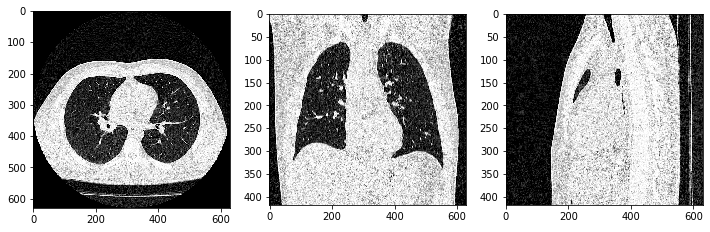

In [4]:
# show the ct images
plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(img[0, img.shape[1]//2, ...], 'gray', aspect=spacing[1] / spacing[2])
plt.subplot(132); plt.imshow(img[0, :, img.shape[2]//2, :], 'gray', aspect=spacing[0] / spacing[2])
plt.subplot(133); plt.imshow(img[0, ..., img.shape[3]//2], 'gray', aspect=spacing[0] / spacing[1])

In [5]:
# setup the projector
projector = ct_projector.ct_projector()
projector.from_file('./projector_fan.cfg')
projector.nx = img.shape[3]
projector.ny = img.shape[2]
projector.nz = img.shape[1]
projector.dx = spacing[2]
projector.dy = spacing[1]
projector.dz = spacing[0]

for k in vars(projector):
    print (k, '=', getattr(projector, k))

nview = 2304
nu = 736
nv = 50
nx = 630
ny = 630
nz = 418
dx = 0.6835939884185791
dy = 0.6835939884185791
dz = 1.0
cx = 0
cy = 0
cz = 0
dsd = 1086.5
dso = 595.0
du = 1.2858
dv = 1.0
off_u = 1.125
off_v = 0
geometry = <configparser.ConfigParser object at 0x7f6a7c3f4dd0>


In [6]:
# very important: use np.copy('C') so that the arrays are saved in C order
angles = projector.get_angles()
img = np.copy(img, 'C')
projector.set_projector(projector.siddon_fan_fp, angles = angles)

In [7]:
# set which device to use
projector.set_device(0)
# forward projection
fp = projector.fp2(img, angles = angles)

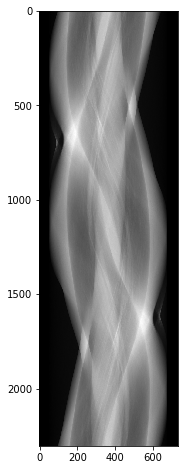

In [8]:
# show the projections
plt.figure(figsize = (8,8))
plt.imshow(fp[0,:, 25, :], 'gray')

In [9]:
fprj = projector.ramp_filter(fp)

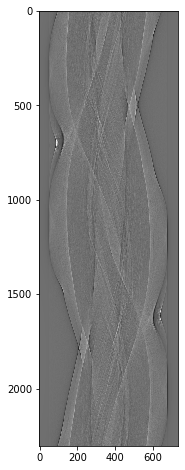

In [10]:
plt.figure(figsize = (8,8))
plt.imshow(fprj[0,:, 25, :], 'gray')

In [11]:
projector.set_backprojector(projector.siddon_fan_bp, angles = angles)
bp = projector.bp2(fprj, angles = angles)

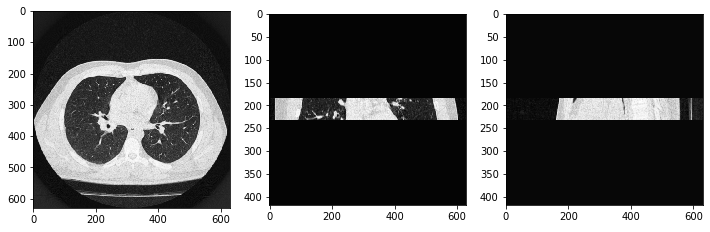

In [12]:
plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(bp[0, bp.shape[1]//2, ...], 'gray', aspect=spacing[1] / spacing[2])
plt.subplot(132); plt.imshow(bp[0, :, bp.shape[2]//2, :], 'gray', aspect=spacing[0] / spacing[2])
plt.subplot(133); plt.imshow(bp[0, ..., bp.shape[3]//2], 'gray', aspect=spacing[0] / spacing[1])

In [13]:
fbp = projector.fbp_fan_bp(fprj, angles = angles)

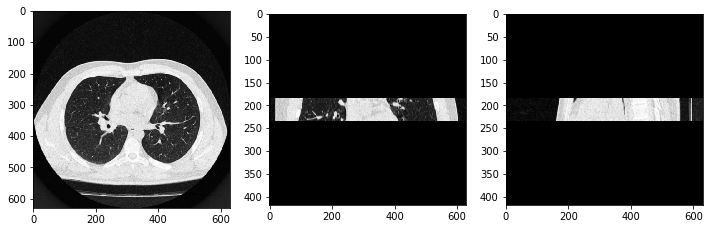

In [14]:
plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(fbp[0, fbp.shape[1]//2, ...], 'gray', aspect=spacing[1] / spacing[2])
plt.subplot(132); plt.imshow(fbp[0, :, fbp.shape[2]//2, :], 'gray', aspect=spacing[0] / spacing[2])
plt.subplot(133); plt.imshow(fbp[0, ..., fbp.shape[3]//2], 'gray', aspect=spacing[0] / spacing[1])